# Finding Lane Lines in the Road

This project develops a pipeline to use on a series of individual images, and later applies the result to a video stream, which is really just a series of images. To see the picture and video outputs, go through the cells in order, typing 'CTRL + ENTER' to run the code.

We will use color and region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection. This means we will take an image, and first of all focus on colors in a certain region of the picture -- in this case, the white and yellow lane lines in the lower triangle of the frame. We will then grayscale the image to render a simpler picture of grey with white lines (grayscaling). Gaussian smoothing then blurs the image to reduce the noise. We use Canny Edge Detection to determine the edges of a white or yellow lane line, linking the dotted paint on the road, 

In [4]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


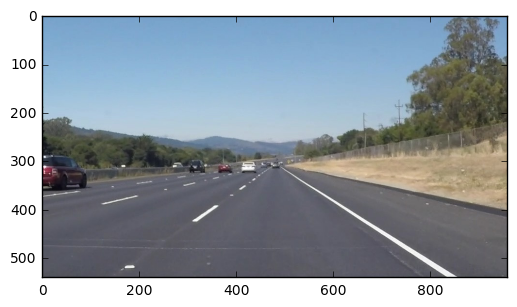

In [5]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

array([[[144, 157, 167],
        [114, 129, 141],
        [107, 125, 143],
        ..., 
        [109, 123, 142],
        [117, 127, 141],
        [149, 156, 168]],

       [[114, 129, 141],
        [114, 133, 147],
        [107, 128, 146],
        ..., 
        [110, 127, 146],
        [114, 127, 143],
        [118, 129, 142]],

       [[105, 126, 143],
        [106, 129, 146],
        [102, 127, 150],
        ..., 
        [103, 125, 148],
        [109, 126, 146],
        [107, 122, 141]],

       ..., 
       [[ 96,  97, 100],
        [ 73,  74,  78],
        [ 66,  67,  71],
        ..., 
        [ 70,  71,  74],
        [ 75,  76,  79],
        [ 96,  97, 100]],

       [[110, 111, 114],
        [ 84,  85,  88],
        [ 71,  72,  76],
        ..., 
        [ 78,  78,  82],
        [ 87,  88,  91],
        [111, 112, 115]],

       [[144, 145, 148],
        [112, 113, 116],
        [ 94,  94,  98],
        ..., 
        [ 98,  98, 100],
        [112, 113, 114],
        [143, 144,

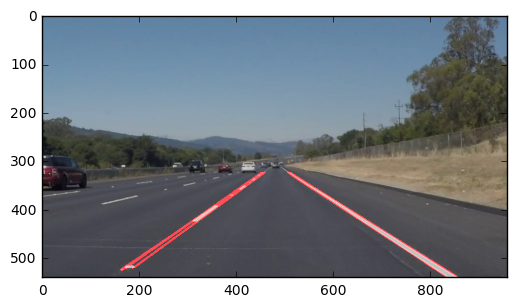

In [6]:
import math

def grayscale(img):
    """Applies the Grayscale transform"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    low_threshold = 50
    high_threshold = 150
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img) 
    ignore_mask_color = 255
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    imshape = image.shape
    vertices = np.array([[(0, imshape[0]), (imshape[1]*14/30, imshape[0]*0.6), 
                          (imshape[1]*16/30, imshape[0]*0.6), (imshape[1], imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    Returns an image with hough lines drawn.
    """
    rho = 1
    theta = np.pi/180
    threshold = 15 
    min_line_length = 40
    max_line_gap = 200
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    hough_image = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(hough_image, lines)
    return hough_image

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    The result image is computed as follows:
    initial image ("image" in this case) * α + img * β + λ
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def process_image(img):
    #run all the functions above in order 
    img = image
    gray_image = grayscale(img)
    gaussian_image = gaussian_blur(gray_image, 5)
    canny_image = canny(gaussian_image, 50, 150)
    imshape = image.shape
    vertices = np.array([[(0, imshape[0]), (imshape[1]*14/30, imshape[0]*0.6), 
                          (imshape[1]*16/30, imshape[0]*0.6), (imshape[1], imshape[0])]], dtype=np.int32)
    masked_image = region_of_interest(canny_image, vertices)
    hough_image = hough_lines(masked_image, 1, np.pi/180, 15, 40, 200)
    final_image = weighted_img(hough_image, img)
    result = final_image
    plt.imshow(result)
    return result

process_image(image)

## Test on Videos
Now the real fun begins. We can test the program's ability to draw lane lines over the sequence of images which make up a video.
We can test our solution on two provided videos:

solidWhiteRight.mp4

solidYellowLeft.mp4

In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [10]:
def process_image(img):
    # The same 'do-all' function as above, this time applied to the video
    gray_image = grayscale(img)
    gaussian_image = gaussian_blur(gray_image, 5)
    canny_image = canny(gaussian_image, 50, 150)
    imshape = image.shape
    vertices = np.array([[(0, imshape[0]), (imshape[1]*14/30, imshape[0]*0.6), 
                          (imshape[1]*16/30, imshape[0]*0.6),
                          (imshape[1], imshape[0])]], dtype=np.int32)
    masked_image = region_of_interest(canny_image, vertices)
    hough_image = hough_lines(masked_image, 1, np.pi/180, 15, 40, 200)
    final_image = weighted_img(hough_image, img, α=0.8, β=1., λ=0.)
    result = final_image
    plt.imshow(result)
    return result


Let's try the one with the solid white lane on the right first ...

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:19<00:00, 11.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 11.3 s, sys: 1.87 s, total: 13.1 s
Wall time: 22 s


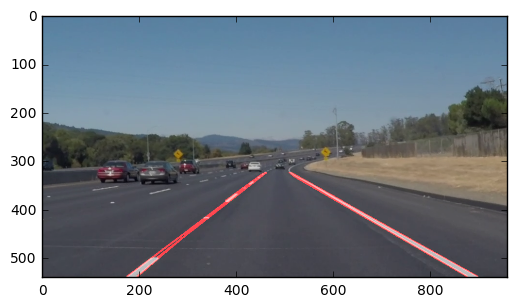

In [11]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for a more challenging example with the lane on the left, and a slight curve in the road.

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [01:17<00:00,  7.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 34.7 s, sys: 6.21 s, total: 40.9 s
Wall time: 1min 20s


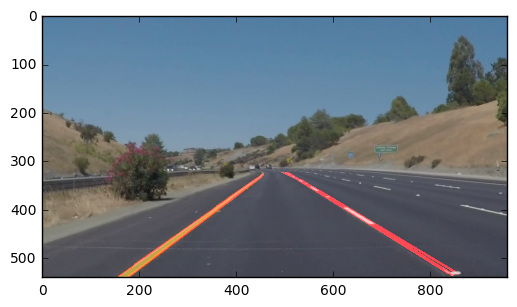

In [10]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))